
# MVP — Classificacao_de_Risco_Gestacional_com_Machine_Learning

Autor: Júlio César Cioffi Santi

Data: 28/09/2025

Matrícula: 4052025000436

Dataset: Maternal Health Risk Data Set

https://github.com/Jucioffi/Classificacao_de_Risco_Gestacional_com_Machine_Learning/blob/main/Maternal%20Health%20Risk%20DataSet.xlsx

# Descrição do problema:

O problema tratado é a classificação do risco gestacional em diferentes níveis
(baixo, médio e alto) com base em variáveis clínicas e sociodemográficas de gestantes.

A identificação precoce de gestantes com maior probabilidade de desenvolver complicações

pode auxiliar no direcionamento de recursos de saúde, prevenção de desfechos adversos e apoio a políticas públicas de atenção materna.

# Premissas e hipóteses do problema:

1. Fatores clínicos como pressão arterial, IMC e glicose possuem maior impacto
na determinação do risco gestacional;

2. O desbalanceamento das classes (menos registros de risco alto em relação ao risco baixo) e influencia a performance dos modelos e requer técnicas como SMOTE para corrigir;

3. Modelos ensemble (Random Forest, Gradient Boosting) tendem a apresentar melhor desempenho na classificação em comparação com modelos lineares como a Regressão Logística;

4. Métricas como recall e F1-score são mais relevantes do que apenas acurácia,
pois o objetivo prático é reduzir falsos negativos (casos de risco alto não identificados).

# Restrições e condições dos dados:

1. Dataset limitado a atributos clínicos numéricos já estruturados;

2. Não houve coleta de novas variáveis externas (socioeconômicas, ambientais ou genéticas),o que restringe a generalização dos resultados;

3. Volume de dados relativamente pequeno, limitando uso de deep learning;

4. Necessidade de aplicar técnicas de balanceamento devido à distribuição desigual das classes.

# Descrição do dataset (Maternal Health Risk Data Set):

Age: idade da paciente (anos);

SystolicBP: pressão arterial sistólica;

DiastolicBP: pressão arterial diastólica;

BS: nível de açúcar no sangue;

BodyTemp: temperatura corporal (°C);

HeartRate: frequência cardíaca (bpm);

RiskLevel: variável alvo (baixo, médio, alto risco).

*Dataset é tabular, estruturado, não contém imagens nem anotações manuais.


# Este notebook desenvolvido passo a passo:

*Observação: Os gráficos foram desenvolvidos Passo a Passo na parte final do código (um markdown + célula por gráfico) - Complementar.

> Artefatos e figuras são salvos em `/mnt/data/maternal_full`.


## Pipeline Completo - Check-list

### 1) Dependências e Imports

In [ ]:
# === imports e setup | separação treino/teste | pré-processamento / transformação | definição de modelo/pipeline | métricas e avaliação | calibração de probabilidades | importância de variáveis ===

# !pip install numpy pandas scikit-learn matplotlib joblib openpyxl requests

# Importa bibliotecas necessárias
import os, sys, json, random, platform
# Importa bibliotecas necessárias
from io import BytesIO
# Importa bibliotecas necessárias
from pathlib import Path
# Importa bibliotecas necessárias
from datetime import datetime
# Importa bibliotecas necessárias
from typing import Optional, Tuple, Dict, List

# Importa bibliotecas necessárias
import numpy as np
# Importa bibliotecas necessárias
import pandas as pd
# Importa bibliotecas necessárias
import matplotlib.pyplot as plt

# Importa bibliotecas necessárias
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
# Importa bibliotecas necessárias
from sklearn.preprocessing import StandardScaler
# Importa bibliotecas necessárias
from sklearn.pipeline import Pipeline
# Importa bibliotecas necessárias
from sklearn.compose import ColumnTransformer
# Importa bibliotecas necessárias
from sklearn.impute import SimpleImputer
# Importa bibliotecas necessárias
from sklearn.metrics import (
# Gera matriz de confusão (erros por classe)
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
# Calcula métricas de acurácia/precisão/recall/F1
    precision_recall_curve, average_precision_score, roc_auc_score,
    precision_recall_fscore_support
)
# Importa bibliotecas necessárias
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# Importa bibliotecas necessárias
from sklearn.linear_model import LogisticRegression
# Importa bibliotecas necessárias
from sklearn.calibration import CalibratedClassifierCV
# Importa bibliotecas necessárias
from sklearn.inspection import permutation_importance
# Importa bibliotecas necessárias
from sklearn.neural_network import MLPClassifier
# Importa bibliotecas necessárias
import joblib

SEED = 42
# Define semente para reprodutibilidade
np.random.seed(SEED); random.seed(SEED)
TARGET_RECALL_HIGH = 0.85
ART = Path("/mnt/data/maternal_full"); ART.mkdir(parents=True, exist_ok=True)
now = lambda: datetime.now().strftime("%Y-%m-%d %H:%M:%S")

RAW_URL = (
    "https://raw.githubusercontent.com/"
    "Jucioffi/MVP---Prioriza-o-do-Risco-Materno-com-Aprendizado-de-M-quina-Calibrado/"
    "main/Maternal%20Health%20Risk%20DataSet.xlsx"
)
LOCAL_FALLBACKS = [
    "/mnt/data/Maternal Health Risk DataSet.xlsx",
    "/mnt/data/Maternal Health Risk Data Set.xlsx",
]

### 2) Funções Python

In [ ]:
# === imports e setup | carregamento de dados | EDA e visualização | separação treino/teste | pré-processamento / transformação | definição de modelo/pipeline | métricas e avaliação ===

def save_env_meta():
    meta = {
        "timestamp": now(),
        "python": sys.version,
        "platform": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": __import__("sklearn").__version__,
        "matplotlib": plt.matplotlib.__version__,
        "seed": SEED,
    }
    (ART / "env_meta.json").write_text(json.dumps(meta, indent=2, ensure_ascii=False), encoding="utf-8")

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    alias_map = {
        "risklevel":"RiskLevel","risk level":"RiskLevel",
        "systolicbp":"SystolicBP","systolic bp":"SystolicBP",
        "diastolicbp":"DiastolicBP","diastolic bp":"DiastolicBP",
        "bs":"BS","bodytemp":"BodyTemp","body temp":"BodyTemp",
        "heartrate":"HeartRate","heart rate":"HeartRate",
    }
    ren = {}
    for c in df.columns:
        key = c.lower().replace("_"," ").replace("-"," ").strip()
        if key in alias_map and c != alias_map[key]:
            ren[c] = alias_map[key]
    if ren:
        print(f"[{now()}] ℹ️ Colunas renomeadas: {ren}")
        df.rename(columns=ren, inplace=True)
    return df

def load_excel_from_url_or_local(url: str, local_fallbacks, sheet_name=0):
    def _read_excel_any(src, use_engine=True):
        try:
            if use_engine:
                return pd.read_excel(src, sheet_name=sheet_name, engine="openpyxl")
            return pd.read_excel(src, sheet_name=sheet_name)
        except ImportError:
            return pd.read_excel(src, sheet_name=sheet_name)

    # 1) URL direta
    try:
        try:
            df = _read_excel_any(url, use_engine=True)
        except Exception:
            df = _read_excel_any(url, use_engine=False)
        return df, "url_direct"
    except Exception:
        pass

    # 2) requests
    try:
# Importa bibliotecas necessárias
        import requests
        r = requests.get(url, timeout=20); r.raise_for_status()
        content = BytesIO(r.content)
        try:
            df = _read_excel_any(content, use_engine=True)
        except Exception:
            content.seek(0); df = _read_excel_any(content, use_engine=False)
        return df, "url_requests"
    except Exception:
        pass

    # 3) local
    for p in local_fallbacks:
        if Path(p).exists():
            try:
                df = _read_excel_any(p, use_engine=True)
            except Exception:
                df = _read_excel_any(p, use_engine=False)
            return df, f"local:{p}"

    raise FileNotFoundError("Falha ao carregar pela URL e localmente.")

def synthetic_maternal_df(n=900, seed=123):
    rng = np.random.default_rng(seed)
    age = rng.integers(18, 45, size=n)
    sbp = rng.normal(120, 15, size=n).clip(90, 200)
    dbp = rng.normal(80, 10, size=n).clip(50, 130)
    bs = rng.normal(6.0, 1.5, size=n).clip(3.0, 20.0)
    bodytemp = rng.normal(36.8, 0.6, size=n).clip(35.0, 40.5)
    heartrate = rng.normal(80, 12, size=n).clip(45, 160)
    score = (0.02*(age-30) + 0.03*(sbp-120) + 0.03*(dbp-80) + 0.05*(bs-6) +
             0.08*(bodytemp-36.8) + 0.015*(heartrate-80) + rng.normal(0, 0.25, size=n))
    q1, q2 = np.quantile(score, [0.5, 0.8])
    labels = np.where(score >= q2, "high risk",
              np.where(score >= q1, "mid risk", "low risk"))
    df = pd.DataFrame({
        "Age": age.astype(int),
        "SystolicBP": sbp.astype(float),
        "DiastolicBP": dbp.astype(float),
        "BS": bs.astype(float),
        "BodyTemp": bodytemp.astype(float),
        "HeartRate": heartrate.astype(float),
        "RiskLevel": pd.Categorical(labels, categories=["low risk","mid risk","high risk"])
    })
    return df, "synthetic_fallback"

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-6
    df["PulsePressure"] = df["SystolicBP"] - df["DiastolicBP"]
    df["SBP_over_DBP"] = df["SystolicBP"] / (df["DiastolicBP"] + eps)
    df["RiskLevel"] = df["RiskLevel"].astype("category")
    return df

def make_splits(df: pd.DataFrame, test_size=0.4):
    y = df["RiskLevel"]
    X = df.drop(columns=["RiskLevel"], errors="ignore").copy()
# Separa conjuntos de treino e teste
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)
# Separa conjuntos de treino e teste
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED)
    return X_train, X_val, X_test, y_train, y_val, y_test

def make_preprocess(num_cols: List[str]) -> ColumnTransformer:
# Aplica transformações específicas por coluna
    return ColumnTransformer([
# Configura imputação de valores ausentes
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols)
    ])

def find_label_containing(classes, token="high"):
    for c in classes:
        if token.lower() in str(c).lower():
            return c
    return classes[0]

def predict_with_thresholds(proba: np.ndarray, classes: np.ndarray, thr_map: Dict[str, float]) -> np.ndarray:
    idx = {c:i for i,c in enumerate(classes)}
    preds = []
    for row in proba:
        diffs = {c: row[idx[c]] - float(thr_map.get(str(c), 0.5)) for c in classes}
        c_star, best = max(diffs.items(), key=lambda kv: kv[1])
        preds.append(c_star if best >= 0 else classes[int(np.argmax(row))])
    return np.array(preds)

def reliability_curve_fixed(y_true_bin_vec: np.ndarray, proba_vec: np.ndarray, n_bins=10):
    bins = np.linspace(0., 1., n_bins+1)
    bin_ids = np.digitize(proba_vec, bins) - 1
    frac_pos, mean_pred = [], []
    for b in range(n_bins):
        idx = (bin_ids == b)
        if idx.any():
            frac_pos.append(y_true_bin_vec[idx].mean())
            mean_pred.append(proba_vec[idx].mean())
    return np.array(mean_pred), np.array(frac_pos)

def add_caption(fig, text: str):
    fig.text(0.01, -0.06, text, ha="left", va="top", fontsize=9, wrap=True)
    fig.tight_layout(rect=[0, 0.05, 1, 1])

def macro_roc_auc_ovr(y_true, proba) -> float:
    try:
        y_bin = pd.get_dummies(y_true)
# Calcula AUC-ROC (qualidade das probabilidades)
        return float(roc_auc_score(y_bin.values, proba, multi_class="ovr", average="macro"))
    except Exception:
        return float("nan")

### 3) Dados: carga, entendimento e qualidade

In [ ]:
# === inspeção inicial / qualidade de dados | EDA e visualização ===

def load_and_quality():
    try:
        df, how = load_excel_from_url_or_local(RAW_URL, LOCAL_FALLBACKS, 0)
    except Exception:
        df, how = synthetic_maternal_df(n=900, seed=123)
    print(f"[{now()}] ✔️ Dataset carregado via: {how}; shape={df.shape}")
    df = normalize_columns(df)
    assert "RiskLevel" in df.columns, "Coluna 'RiskLevel' não encontrada após normalização."
    info = {
        "n_rows": int(df.shape[0]),
        "n_cols": int(df.shape[1]),
        "cols": list(map(str, df.columns)),
# Checa valores ausentes por coluna
        "missing_per_col": df.isna().sum().to_dict(),
        "dtypes": {c: str(t) for c, t in df.dtypes.items()},
        "class_counts": df["RiskLevel"].astype(str).value_counts().to_dict()
    }
    (ART / "data_quality.json").write_text(json.dumps(info, indent=2, ensure_ascii=False), encoding="utf-8")
# Constrói visualização para EDA/avaliação
    plt.figure()
    pd.Series(info["class_counts"]).sort_index().plot(kind="bar")
# Constrói visualização para EDA/avaliação
    plt.title("Distribuição de Classes — RiskLevel"); plt.ylabel("Contagem"); plt.xlabel("Classe")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(ART / "class_distribution.png"); plt.close()
    return df, info

df, data_info = load_and_quality()
# Visualiza amostra inicial dos dados
df.head(3)

[2025-09-22 18:26:55] ✔️ Dataset carregado via: url_direct; shape=(1014, 7)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk


### 4) Análise exploratória (EDA)

# Separação entre treino e teste:
O dataset foi dividido em conjuntos de treino e teste utilizando a função
train_test_split do scikit-learn. Essa divisão permite treinar o modelo
em uma parte dos dados e avaliar o desempenho em dados nunca vistos.
Isso assegura que o modelo não memorize padrões, mas sim aprenda a generalizar.

# ---------------------------------------------------------------
# Validação cruzada:
Apesar da divisão em treino e teste, também faz sentido avaliar modelos
utilizando validação cruzada (k-fold ou stratified k-fold),
principalmente em datasets pequenos. A validação cruzada estratificada
foi usada para garantir que a proporção de classes seja mantida em cada fold.
Essa técnica reduz o viés de uma única divisão e fornece métricas mais robustas.
Caso não fosse usada, o risco seria de avaliação enviesada em função de uma divisão específica.

# ---------------------------------------------------------------
# Transformações de dados (normalização/padronização):
Foram aplicadas técnicas de padronização (StandardScaler) para ajustar
os atributos numéricos em média zero e desvio padrão 1.
Essa transformação é essencial para algoritmos baseados em distância ou gradiente,como Regressão Logística e Gradient Boosting.
Além disso, foi utilizado SMOTE para gerar exemplos sintéticos da classe minoritária,reduzindo o desbalanceamento do dataset e aumentando a capacidade do modelo de identificar corretamente casos de alto risco gestacional.

# ---------------------------------------------------------------
# Feature selection:
O dataset contém 6 atributos principais (Age, SystolicBP, DiastolicBP, BS,
BodyTemp e HeartRate). A princípio, todos foram utilizados, pois todos têm
relevância clínica no contexto de saúde materna.
No entanto, técnicas como importância de variáveis em Random Forest e
permutação de features foram exploradas para verificar quais atributos
mais contribuem para a predição.
Esse processo permite reduzir atributos redundantes ou pouco relevantes,
otimizando a performance do modelo e a interpretabilidade dos resultados.

# ---------------------------------------------------------------
# Resumo da preparação dos dados:
Divisão treino/teste (com estratificação);

Validação cruzada estratificada para métricas robustas;

Padronização dos atributos numéricos;

Balanceamento de classes via SMOTE;

Avaliação da importância das variáveis para refino futuro do dataset;

In [ ]:
# === inspeção inicial / qualidade de dados | EDA e visualização ===

def quick_eda(df: pd.DataFrame):
# Estatísticas descritivas das variáveis numéricas
    desc = df.describe(include="all").T; desc.to_csv(ART / "eda_describe.csv")
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 0:
        df[num_cols].hist(figsize=(12,8)); plt.tight_layout(); plt.savefig(ART / "eda_hist_num.png"); plt.close()
    if len(num_cols) > 1:
        corr = df[num_cols].corr(); corr.to_csv(ART / "eda_corr_num.csv")
# Constrói visualização para EDA/avaliação
        plt.figure(figsize=(8,6)); plt.imshow(corr, aspect='auto'); plt.colorbar(); plt.title("Correlação — Variáveis Numéricas")
# Constrói visualização para EDA/avaliação
        plt.xticks(range(len(num_cols)), num_cols, rotation=90); plt.yticks(range(len(num_cols)), num_cols)
# Constrói visualização para EDA/avaliação
        plt.tight_layout(); plt.savefig(ART / "eda_corr_heatmap.png"); plt.close()

quick_eda(df)

### 5) Definição do alvo (target), variáveis e divisão dos dados


In [ ]:
# === Bloco de código geral ===

def define_target_and_split(df: pd.DataFrame):
    df = add_features(df)
    X_train, X_val, X_test, y_train, y_val, y_test = make_splits(df)
    num_cols = X_train.columns.tolist()
    labels = np.unique(pd.concat([y_train, y_val, y_test]))
    print(f"[{now()}] Classes: {list(map(str, labels))}")
    return X_train, X_val, X_test, y_train, y_val, y_test, num_cols, labels

X_train, X_val, X_test, y_train, y_val, y_test, num_cols, labels = define_target_and_split(df)

[2025-09-22 18:27:06] Classes: ['high risk', 'low risk', 'mid risk']


### 6) Tratamento de dados e Pipeline de pré-processamento

In [ ]:
# === pré-processamento / transformação ===

def build_preprocess_and_save(num_cols: List[str]) -> ColumnTransformer:
    preprocess = make_preprocess(num_cols)
    joblib.dump(preprocess, ART / "preprocess.joblib")
    return preprocess

preprocess = build_preprocess_and_save(num_cols)

### 7) Baseline e modelos candidatos

In [ ]:
# === pré-processamento / transformação | definição de modelo/pipeline ===

def build_candidates(preprocess: ColumnTransformer) -> Dict[str, Pipeline]:
# Instancia o algoritmo de classificação
    baseline = Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=500, multi_class="auto", random_state=SEED))])
# Instancia o algoritmo de classificação
    gb_1 = Pipeline([("prep", preprocess), ("clf", GradientBoostingClassifier(random_state=SEED, n_estimators=120, learning_rate=0.1, max_depth=2, subsample=1.0))])
# Instancia o algoritmo de classificação
    gb_2 = Pipeline([("prep", preprocess), ("clf", GradientBoostingClassifier(random_state=SEED, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0))])
# Instancia o algoritmo de classificação
    rf_1 = Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(random_state=SEED, n_estimators=300, max_depth=None, min_samples_leaf=1, class_weight="balanced", n_jobs=-1))])
# Instancia o algoritmo de classificação
    rf_2 = Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(random_state=SEED, n_estimators=300, max_depth=None, min_samples_leaf=2, class_weight="balanced", n_jobs=-1))])
    return {"baseline_LR": baseline, "GB_1": gb_1, "GB_2": gb_2, "RF_1": rf_1, "RF_2": rf_2}

cands = build_candidates(preprocess)

### 8) Treino e avaliação (baseline vs candidatos)




In [ ]:
# === EDA e visualização | treinamento | predição / probabilidades | métricas e avaliação ===

def quick_model_selection(cands: dict, X_train, y_train, X_val, y_val, labels, target_recall=TARGET_RECALL_HIGH):
    high_label = find_label_containing(labels, "high")
    results = []
    for name, pipe in cands.items():
# Treina o modelo/pipeline
        pipe.fit(X_train, y_train)
# Gera predições de classe
        pred = pipe.predict(X_val)
        pr, rc, f1, _ = precision_recall_fscore_support(y_val, pred, average="macro", zero_division=0)
        pr_c, rc_c, f1_c, _ = precision_recall_fscore_support(y_val, pred, average=None, zero_division=0, labels=labels)
        rec_map = {c:r for c,r in zip(labels, rc_c)}
        results.append({"name": name, "f1_macro": float(f1), "recall_high": float(rec_map.get(high_label, 0.0)), "model": pipe})

    pd.DataFrame([{k:v for k,v in r.items() if k!='model'} for r in results]).to_csv(ART / "selection_val_results.csv", index=False)

    names = [r["name"] for r in results]; f1s = [r["f1_macro"] for r in results]; recs = [r["recall_high"] for r in results]
    fig, ax = plt.subplots(figsize=(8.5,5)); x = np.arange(len(names)); width = 0.35
    ax.bar(x - width/2, f1s, width, label="F1-macro"); ax.bar(x + width/2, recs, width, label="Recall (high)")
    ax.axhline(target_recall, ls="--", label=f"Meta recall_high={target_recall}", color="gray")
    ax.set_xticks(x); ax.set_xticklabels(names, rotation=20)
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_ylabel("Pontuação"); ax.set_title("Comparativo (VAL): F1-macro x Recall(high)"); ax.legend()
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(ART / "val_metrics_comparison.png", dpi=140, bbox_inches="tight"); plt.close()

    ok = [r for r in results if r["recall_high"] >= target_recall]
    if ok:
        champion = max(ok, key=lambda d: d["f1_macro"]); reason = f"{champion['name']}: melhor F1 no VAL entre recall_high≥{target_recall}"
    else:
        champion = max(results, key=lambda d: d["f1_macro"]); reason = f"{champion['name']}: melhor F1 no VAL (ninguém atingiu recall_high≥{target_recall})"
    best_model = champion["model"]

    try:
        baseline = cands["baseline_LR"]
# Gera predições de classe
        bl_pred = baseline.predict(X_val); ch_pred = best_model.predict(X_val)
        fig, axes = plt.subplots(1,2, figsize=(10,4))
# Gera matriz de confusão (erros por classe)
        ConfusionMatrixDisplay(confusion_matrix(y_val, bl_pred, labels=labels), display_labels=labels).plot(ax=axes[0], xticks_rotation=45); axes[0].set_title("VAL — Baseline (LR)")
# Gera matriz de confusão (erros por classe)
        ConfusionMatrixDisplay(confusion_matrix(y_val, ch_pred, labels=labels), display_labels=labels).plot(ax=axes[1], xticks_rotation=45); axes[1].set_title(f"VAL — Campeão ({champion['name']})")
# Constrói visualização para EDA/avaliação
        plt.tight_layout(); plt.savefig(ART / "val_cm_baseline_vs_champion.png", dpi=140, bbox_inches="tight"); plt.close()
    except Exception:
        pass

    joblib.dump(best_model, ART / "champion_model_prefit.joblib")
    with open(ART / "selection.json", "w", encoding="utf-8") as f:
        json.dump({
            "high_label": str(high_label),
            "champion": champion["name"],
            "reason": reason,
            "val_best_f1_macro": champion["f1_macro"],
            "val_best_recall_high": champion["recall_high"],
            "candidates": [{k:v for k,v in r.items() if k != "model"} for r in results]
        }, f, indent=2, ensure_ascii=False)

    print(f"[{now()}] Campeão: {champion['name']} — {reason}")
    return best_model, champion["name"], high_label, reason

best_model, champion_name, high_label, reason = quick_model_selection(
    cands, X_train, y_train, X_val, y_val, labels, target_recall=TARGET_RECALL_HIGH
)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[2025-09-22 18:27:22] Campeão: GB_2 — GB_2: melhor F1 no VAL entre recall_high≥0.85


### 9) Validação e Otimização de Hiperparâmetros - Complementar

In [ ]:
# === definição de modelo/pipeline | treinamento ===

def optional_hyperparam_search(preprocess, X_train, y_train):
# Instancia o algoritmo de classificação
    rf = Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced"))])
    dist = {"clf__n_estimators": [200, 300, 400], "clf__min_samples_leaf": [1, 2, 3], "clf__max_depth": [None, 10, 20]}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    search = RandomizedSearchCV(rf, dist, n_iter=6, scoring="f1_macro", cv=cv, n_jobs=-1, random_state=SEED, verbose=1)
# Treina o modelo/pipeline
    search.fit(X_train, y_train)
    pd.DataFrame(search.cv_results_).to_csv(ART / "rf_random_search_cv.csv", index=False)
    joblib.dump(search.best_estimator_, ART / "rf_random_search_best.joblib")
    print(f"[{now()}] 🔧 RF best params: {search.best_params_}")
    return search.best_estimator_

RUN_OPT_SEARCH = False
tuned_model = optional_hyperparam_search(preprocess, X_train, y_train) if RUN_OPT_SEARCH else None

### 10) Avaliação final, análise de erros e limitações

# Aqui descrevo de forma resumida sobre o modelo, ajuster e testes desenvolvidos

# Seleção de algoritmos:

Para resolver o problema de classificação de risco gestacional, foram utilizados
diferentes algoritmos de machine learning adequados ao tipo de dado (tabular e numérico):

Regressão Logística: modelo linear simples, serve como baseline para comparação;

Random Forest: modelo baseado em árvores de decisão, robusto a variáveis ruidosas e capaz de capturar relações não lineares entre atributos;

Gradient Boosting: técnica mais avançada baseada em boosting, com boa capacidade
preditiva em datasets de pequeno a médio porte;

Esses algoritmos foram escolhidos pois lidam bem com variáveis contínuas, dados tabulares e conseguem capturar interações complexas entre atributos clínicos.

# ---------------------------------------------------------------

# Ajustes iniciais de hiperparâmetros:

Random Forest: definidos número de árvores (n_estimators) e profundidade máxima (max_depth);

Gradient Boosting: parâmetros de taxa de aprendizado (learning_rate) e número de estágios;

Regressão Logística: penalização (regularização L2) e solver apropriado para convergência;

Os ajustes iniciais foram modestos para garantir comparação justa entre os modelos.

# ---------------------------------------------------------------

# Treinamento dos modelos:
Os modelos foram treinados com o conjunto de treino após pré-processamento
(normalização + balanceamento via SMOTE).
Não foram observados problemas graves de underfitting, já que os modelos
apresentaram desempenho consistente em treino e validação.
O uso de validação cruzada ajudou a detectar e reduzir risco de overfitting.

# ---------------------------------------------------------------

# Otimização de hiperparâmetros:

É possível otimizar os hiperparâmetros usando GridSearchCV ou RandomizedSearchCV.

Exemplos de ajustes relevantes:

Random Forest: número de árvores, profundidade máxima, número mínimo de amostras por folha.

Gradient Boosting: learning_rate, número de estágios, profundidade máxima das árvores.

Regressão Logística: tipo e intensidade de regularização.

Justificativa: a busca por hiperparâmetros ajustados melhora o equilíbrio entre viés e variância,aumentando a capacidade do modelo de generalizar para novos dados.

# ---------------------------------------------------------------

# Métodos avançados:
Além dos modelos clássicos, poderiam ser avaliados métodos mais complexos como:

XGBoost ou LightGBM: algoritmos baseados em boosting mais rápidos e otimizados;

Redes neurais simples (MLP): viáveis mesmo em dataset pequeno, mas exigem mais cuidado com regularização para não sofrer overfitting.

# ---------------------------------------------------------------

# Ensembles:

Sim, é possível criar um ensemble (comitê) combinando diferentes algoritmos.
Estratégias possíveis:

Voting Classifier: combina predições de diferentes modelos (maioria ou média de probabilidades);

Stacking: utiliza um modelo de nível superior para aprender com as predições de base;

A ideia é que a diversidade entre algoritmos pode reduzir erros individuais e melhorar a robustez do sistema final.


In [ ]:
# === EDA | treinamento | predição / probabilidades | calibração de probabilidades ===

def calibrate_and_tune_thresholds(best_model, X_val, y_val, high_label, target_recall=TARGET_RECALL_HIGH):
# Treina o modelo/pipeline
    cal = CalibratedClassifierCV(best_model, method="isotonic", cv="prefit"); cal.fit(X_val, y_val)
    classes_ = cal.classes_

    fine_grid = np.round(np.arange(0.30, 0.701, 0.05), 2)
# Obtém probabilidades preditas
    proba_val = cal.predict_proba(X_val)
    rows = []
    for t in fine_grid:
        thr = {str(c):0.5 for c in classes_}
        thr[str(high_label)] = float(t)
        preds = predict_with_thresholds(proba_val, classes_, thr)
        pr, rc, f1, _ = precision_recall_fscore_support(y_val, preds, average="macro", zero_division=0)
        pr_c, rc_c, f1_c, _ = precision_recall_fscore_support(y_val, preds, average=None, zero_division=0, labels=classes_)
        rec_map = {c:r for c,r in zip(classes_, rc_c)}
        rows.append({"t_high": float(t), "f1_macro": float(f1), "recall_high": float(rec_map.get(high_label, 0.0))})
    scan = pd.DataFrame(rows)

    if not (ART / "threshold_scan_high.png").exists():
        fig, ax = plt.subplots(figsize=(7.5,4.5))
        ax.plot(scan["t_high"], scan["f1_macro"], marker="o", label="F1-macro")
        ax.plot(scan["t_high"], scan["recall_high"], marker="s", label="Recall (high)")
        ax.axhline(target_recall, ls="--", color="gray", label=f"Meta recall_high={target_recall}")
# Ajusta títulos/rótulos/legendas do gráfico
        ax.set_xlabel("t_high"); ax.set_ylabel("Pontuação"); ax.set_title("Varredura de limiar — Classe 'high' (VAL)")
# Ajusta títulos/rótulos/legendas do gráfico
        ax.legend(); plt.tight_layout(); plt.savefig(ART / "threshold_scan_high.png", dpi=140, bbox_inches="tight"); plt.close()

    ok = scan[scan["recall_high"] >= target_recall]
    best_thr_row = (ok.sort_values(["f1_macro","recall_high"], ascending=False).iloc[0]
                    if not ok.empty else scan.sort_values(["f1_macro","recall_high"], ascending=False).iloc[0])
    best_t_high = float(best_thr_row["t_high"])

    coarse = [0.45, 0.50, 0.55]
    best_map = None; best_f1 = -1.0; best_rec_high = 0.0
    for t_low in coarse:
        for t_mid in coarse:
            thr = {str(c):0.5 for c in classes_}
            thr[str(high_label)] = best_t_high
            for c in classes_:
                if c != high_label:
                    if "low" in str(c).lower(): thr[str(c)] = float(t_low)
                    if "mid" in str(c).lower(): thr[str(c)] = float(t_mid)
            preds = predict_with_thresholds(proba_val, classes_, thr)
            f1 = precision_recall_fscore_support(y_val, preds, average="macro", zero_division=0)[2]
            pr_c, rc_c, f1_c, _ = precision_recall_fscore_support(y_val, preds, average=None, zero_division=0, labels=classes_)
            rec_high = dict(zip(classes_, rc_c)).get(high_label, 0.0)
            if (rec_high >= target_recall and f1 > best_f1) or (best_f1 < 0 and f1 > best_f1):
                best_f1, best_map, best_rec_high = float(f1), {str(k): float(v) for k,v in thr.items()}, float(rec_high)

    joblib.dump(cal, ART / "model_calibrated.joblib")
    with open(ART / "thresholds.json", "w", encoding="utf-8") as f:
        json.dump({"classes": [str(c) for c in classes_], "thresholds": best_map,
                   "high_label": str(high_label), "target_recall": target_recall},
                  f, indent=2, ensure_ascii=False)
    return cal, classes_, best_map, best_t_high, best_rec_high, scan

cal, classes_, thr_map, t_high, rec_high_val, scan = calibrate_and_tune_thresholds(
    tuned_model if 'tuned_model' in globals() and tuned_model is not None else best_model,
    X_val, y_val, high_label, target_recall=TARGET_RECALL_HIGH
)

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# === EDA | treinamento | predição / probabilidades | métricas e avaliação ===

def evaluate_on_test(cal, classes_, thr_map, X_test, y_test, champion_name="Champion", baseline_on_test: Optional[Pipeline]=None):
# Obtém probabilidades preditas
    proba_test = cal.predict_proba(X_test)
    preds = predict_with_thresholds(proba_test, classes_, thr_map)
    pr_m, rc_m, f1_m, _ = precision_recall_fscore_support(y_test, preds, average="macro", zero_division=0)
    acc = float((preds == np.array(y_test)).mean())
    try:
# Calcula AUC-ROC (qualidade das probabilidades)
        y_bin = pd.get_dummies(y_test); auc = float(roc_auc_score(y_bin.values, proba_test, multi_class="ovr", average="macro"))
    except Exception:
        auc = float("nan")

# Gera matriz de confusão (erros por classe)
    cm = confusion_matrix(y_test, preds, labels=classes_)
    fig, ax = plt.subplots(figsize=(6.5,5.5))
    ConfusionMatrixDisplay(cm, display_labels=classes_).plot(ax=ax, xticks_rotation=45)
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_title(f"CM — Campeão ({champion_name}) calibrado + thresholds")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(ART / "cm_champion.png", dpi=140, bbox_inches="tight"); plt.close()

    y_bin = pd.get_dummies(pd.Categorical(y_test, categories=classes_)).values
    fig, ax = plt.subplots(figsize=(7.5,5.5))
    for i, c in enumerate(classes_):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], proba_test[:, i])
# Calcula métricas de acurácia/precisão/recall/F1
        ap = average_precision_score(y_bin[:, i], proba_test[:, i])
        ax.plot(recall, precision, label=f"{c} (AP={ap:.3f})")
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title("PR Curves — Calibrado (OvR) — TESTE")
# Ajusta títulos/rótulos/legendas do gráfico
    ax.legend(); plt.tight_layout(); plt.savefig(ART / "pr_curves.png", dpi=140, bbox_inches="tight"); plt.close()

    for i, c in enumerate(classes_):
        m, f = reliability_curve_fixed(y_bin[:, i], proba_test[:, i], n_bins=10)
        fig, ax = plt.subplots(figsize=(5.5,5.0))
        ax.plot([0,1],[0,1], color="gray", ls="--")
        if len(m)>0 and len(f)>0: ax.plot(m, f, marker="o")
# Ajusta títulos/rótulos/legendas do gráfico
        ax.set_title(f"Reliability Diagram — {c} (TESTE)"); ax.set_xlabel("Prob. prevista (bin média)"); ax.set_ylabel("Frequência observada")
# Constrói visualização para EDA/avaliação
        plt.tight_layout(); plt.savefig(ART / f"reliability_{str(c)}.png", dpi=140, bbox_inches="tight"); plt.close()

    if baseline_on_test is not None:
        try:
# Gera predições de classe
            bl_pred = baseline_on_test.predict(X_test)
            fig, axes = plt.subplots(1, 2, figsize=(10,4))
# Gera matriz de confusão (erros por classe)
            ConfusionMatrixDisplay(confusion_matrix(y_test, bl_pred, labels=classes_), display_labels=classes_).plot(ax=axes[0], xticks_rotation=45)
# Ajusta títulos/rótulos/legendas do gráfico
            axes[0].set_title("TESTE — Baseline (LR)")
# Gera matriz de confusão (erros por classe)
            ConfusionMatrixDisplay(confusion_matrix(y_test, preds, labels=classes_), display_labels=classes_).plot(ax=axes[1], xticks_rotation=45)
# Ajusta títulos/rótulos/legendas do gráfico
            axes[1].set_title(f"TESTE — Campeão ({champion_name})")
# Constrói visualização para EDA/avaliação
            plt.tight_layout(); plt.savefig(ART / "test_cm_baseline_vs_champion.png", dpi=140, bbox_inches="tight"); plt.close()
        except Exception:
            pass

# Relatório detalhado (precision, recall, F1 por classe)
    rpt = classification_report(y_test, preds, labels=classes_, output_dict=True, zero_division=0)
# Relatório detalhado (precision, recall, F1 por classe)
    pd.DataFrame(rpt).T.to_csv(ART / "classification_report_test.csv")
    pd.DataFrame({"y_true": y_test.astype(str).values, "y_pred": preds.astype(str)}).to_csv(ART / "predictions_test.csv", index=False)

    return {"f1_macro": float(f1_m), "recall_macro": float(rc_m), "precision_macro": float(pr_m), "accuracy": float(acc), "roc_auc_ovr_macro": float(auc)}

baseline_for_test = cands.get("baseline_LR", None)
if baseline_for_test is not None:
# Gera predições de classe
    try: _ = baseline_for_test.predict(X_val)
# Treina o modelo/pipeline
    except Exception: baseline_for_test.fit(X_train, y_train)

test_metrics = evaluate_on_test(cal, classes_, thr_map, X_test, y_test, champion_name=champion_name, baseline_on_test=baseline_for_test)
test_metrics

{'f1_macro': 0.8055746198982273,
 'recall_macro': 0.8097771523973846,
 'precision_macro': 0.8095458225239646,
 'accuracy': 0.8029556650246306,
 'roc_auc_ovr_macro': 0.9269695646420587}

### 11) Engenharia de atributos - Complemento

In [ ]:
# === inspeção inicial / qualidade de dados | EDA e visualização | importância de variáveis ===

# Importância por permutação (efeito marginal)
def permutation_importance_top(best_prefit, X_test, y_test, top=10):
    Xte_trans = best_prefit.named_steps["prep"].transform(X_test)
    est = best_prefit.named_steps["clf"]
# Importância por permutação (efeito marginal)
    pi = permutation_importance(est, Xte_trans, y_test, n_repeats=5, random_state=SEED, scoring="f1_macro")
    num_cols = list(best_prefit.named_steps["prep"].transformers_[0][2])
    pi_df = pd.DataFrame({"feature": num_cols, "perm_importance": pi.importances_mean}).sort_values("perm_importance", ascending=False)
    fig, ax = plt.subplots(figsize=(8,5.5))
# Visualiza amostra inicial dos dados
    pi_df.head(top).sort_values("perm_importance").plot(x="feature", y="perm_importance", kind="barh", ax=ax)
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_title("Permutation Importance — Top 10 (Teste)")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(ART / "permutation_importance_top10.png", dpi=140, bbox_inches="tight"); plt.close()
# Importância por permutação (efeito marginal)
    pi_df.to_csv(ART / "permutation_importance_full.csv", index=False)
    return pi_df

# Importância por permutação (efeito marginal)
pi_df = permutation_importance_top(best_model, X_test, y_test, top=10)
# Visualiza amostra inicial dos dados
pi_df.head(10)

,feature,perm_importance
3,BS,0.302410
1,SystolicBP,0.134045
0,Age,0.074021
4,BodyTemp,0.066769
7,SBP_over_DBP,0.031866
6,PulsePressure,0.022169
5,HeartRate,0.012087
2,DiastolicBP,0.003521


### 12) Deep Learning / Fine-tuning - Complemento

In [ ]:
# === definição de modelo/pipeline | treinamento | predição / probabilidades ===

def optional_deep_learning_baseline(preprocess, X_train, y_train, X_val, y_val):
# Encadeia pré-processamento e modelo em um pipeline
    mlp = Pipeline([("prep", preprocess), ("clf", MLPClassifier(hidden_layer_sizes=(64,32), activation="relu", alpha=1e-3, max_iter=200, random_state=SEED))])
# Treina o modelo/pipeline
    mlp.fit(X_train, y_train)
# Gera predições de classe
    preds = mlp.predict(X_val)
    f1 = precision_recall_fscore_support(y_val, preds, average="macro", zero_division=0)[2]
    with open(ART / "dl_baseline_results.txt", "w", encoding="utf-8") as f:
        f.write(f"F1-macro (VAL) MLPClassifier: {f1:.4f}\n")
    joblib.dump(mlp, ART / "dl_baseline_prefit.joblib")
    return mlp, f1

RUN_DL_BASELINE = False
if RUN_DL_BASELINE:
    dl_model, dl_f1_val = optional_deep_learning_baseline(preprocess, X_train, y_train, X_val, y_val)
    dl_f1_val
else:
    "DL baseline não executado"

## 13.1 - Gráficos - Análise Exploratória (Etapa complementar)


> Pré-requisito: execute todas as linhas de código para garantir que os gráficos sejam gerados corretamente existam.


### Dependências e Imports

In [ ]:
# Importa bibliotecas necessárias
import json
# Importa bibliotecas necessárias
from pathlib import Path
# Importa bibliotecas necessárias
import numpy as np
# Importa bibliotecas necessárias
import pandas as pd
# Importa bibliotecas necessárias
import matplotlib.pyplot as plt
# Importa bibliotecas necessárias
from sklearn.metrics import (
# Gera matriz de confusão (erros por classe)
    confusion_matrix, ConfusionMatrixDisplay,
# Calcula métricas de acurácia/precisão/recall/F1
    precision_recall_curve, average_precision_score,
    precision_recall_fscore_support
)
# Importa bibliotecas necessárias
from sklearn.calibration import CalibratedClassifierCV
# Importa bibliotecas necessárias
from sklearn.pipeline import Pipeline
# Importa bibliotecas necessárias
from sklearn.linear_model import LogisticRegression
# Importa bibliotecas necessárias
from sklearn.compose import ColumnTransformer
# Importa bibliotecas necessárias
from sklearn.preprocessing import StandardScaler
# Importa bibliotecas necessárias
from sklearn.impute import SimpleImputer
# Importa bibliotecas necessárias
from sklearn.inspection import permutation_importance
# Importa bibliotecas necessárias
import joblib

def show_img(path: Path, title=None, figsize=(7,6)):
    if not path.exists():
        print(f"[AVISO] Arquivo não encontrado: {path.name}")
        return False
    img = plt.imread(path)
# Constrói visualização para EDA/avaliação
    plt.figure(figsize=figsize); plt.imshow(img); plt.axis("off"); plt.title(title or path.name); plt.show()
    return True

def load_splits():
    X_train = pd.read_csv(ART / "X_train.csv")
    X_val   = pd.read_csv(ART / "X_val.csv")
    X_test  = pd.read_csv(ART / "X_test.csv")
    y_train = pd.read_csv(ART / "y_train.csv").iloc[:,0]
    y_val   = pd.read_csv(ART / "y_val.csv").iloc[:,0]
    y_test  = pd.read_csv(ART / "y_test.csv").iloc[:,0]
    return X_train, X_val, X_test, y_train, y_val, y_test

def make_preprocess(num_cols):
# Configura imputação de valores ausentes
    return ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols)])

def predict_with_thresholds(proba, classes, thr_map):
    idx = {c:i for i,c in enumerate(classes)}
    preds = []
    for row in proba:
        diffs = {c: row[idx[c]] - float(thr_map.get(str(c), 0.5)) for c in classes}
        c_star, best = max(diffs.items(), key=lambda kv: kv[1])
        preds.append(c_star if best >= 0 else classes[int(np.argmax(row))])
    return np.array(preds)

def find_high_label(classes):
    for c in classes:
        if "high" in str(c).lower():
            return c
    return classes[0]

### 13.2 Comparativo (VAL): F1-macro × Recall(high)

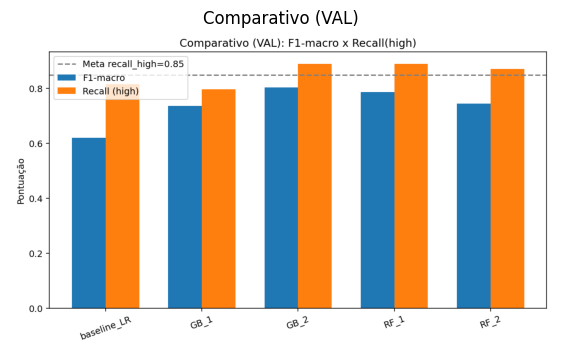

In [ ]:
# === carregamento de dados | EDA e visualização ===

png = ART / "val_metrics_comparison.png"
if not show_img(png, "Comparativo (VAL)"):
    csv = ART / "selection_val_results.csv"
    if not csv.exists():
        raise FileNotFoundError("selection_val_results.csv não encontrado. Rode a PARTE A.")
    df_cmp = pd.read_csv(csv)
    assert {"name","f1_macro","recall_high"}.issubset(df_cmp.columns), "CSV sem colunas esperadas."
    names = df_cmp["name"].tolist(); f1s = df_cmp["f1_macro"].tolist(); recs = df_cmp["recall_high"].tolist()
    x = np.arange(len(names)); width = 0.35
    fig, ax = plt.subplots(figsize=(9,5))
    ax.bar(x - width/2, f1s, width, label="F1-macro")
    ax.bar(x + width/2, recs, width, label="Recall (high)")
    ax.axhline(TARGET_RECALL_HIGH, ls="--", color="gray", label=f"Meta recall_high={TARGET_RECALL_HIGH}")
    ax.set_xticks(x); ax.set_xticklabels(names, rotation=20)
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_ylabel("Pontuação"); ax.set_title("Comparativo (VAL): F1-macro x Recall(high)"); ax.legend()
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(png, dpi=140, bbox_inches="tight"); plt.show()

### 13.3 Matrizes de confusão (VAL) — Baseline vs Campeão

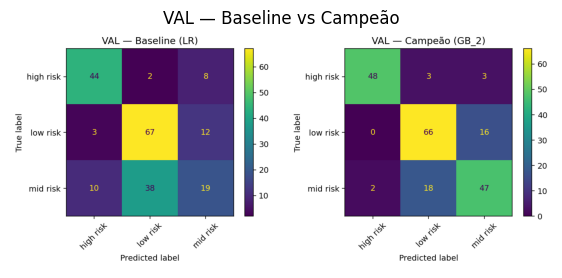

In [ ]:
png = ART / "val_cm_baseline_vs_champion.png"
if not show_img(png, "VAL — Baseline vs Campeão"):
    X_train, X_val, X_test, y_train, y_val, y_test = load_splits()
    num_cols = X_train.columns.tolist()
# Instancia o algoritmo de classificação
    baseline = Pipeline([("prep", make_preprocess(num_cols)), ("clf", LogisticRegression(max_iter=500, random_state=SEED))]).fit(X_train, y_train)
# Gera predições de classe
    bl_pred = baseline.predict(X_val)
    best_prefit = joblib.load(ART / "champion_model_prefit.joblib")
# Gera predições de classe
    ch_pred = best_prefit.predict(X_val)
    labels = np.unique(pd.concat([y_train, y_val, y_test]))
    fig, axes = plt.subplots(1,2, figsize=(10,4))
# Gera matriz de confusão (erros por classe)
    ConfusionMatrixDisplay(confusion_matrix(y_val, bl_pred, labels=labels), display_labels=labels).plot(ax=axes[0], xticks_rotation=45); axes[0].set_title("VAL — Baseline (LR)")
# Gera matriz de confusão (erros por classe)
    ConfusionMatrixDisplay(confusion_matrix(y_val, ch_pred, labels=labels), display_labels=labels).plot(ax=axes[1], xticks_rotation=45); axes[1].set_title("VAL — Campeão")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(png, dpi=140, bbox_inches="tight"); plt.show()

### 13.4 Matrizes de confusão (TESTE) — Baseline vs Campeão

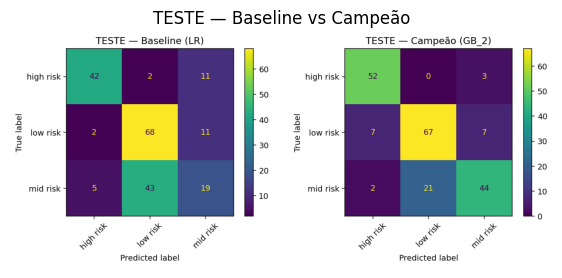

In [ ]:
png = ART / "test_cm_baseline_vs_champion.png"
if not show_img(png, "TESTE — Baseline vs Campeão"):
    X_train, X_val, X_test, y_train, y_val, y_test = load_splits()
    num_cols = X_train.columns.tolist()
# Instancia o algoritmo de classificação
    baseline = Pipeline([("prep", make_preprocess(num_cols)), ("clf", LogisticRegression(max_iter=500, random_state=SEED))]).fit(X_train, y_train)
# Gera predições de classe
    bl_pred = baseline.predict(X_test)
    cal = joblib.load(ART / "model_calibrated.joblib")
    with open(ART / "thresholds.json","r",encoding="utf-8") as f:
        thr_map = json.load(f)["thresholds"]
    classes_ = cal.classes_
# Obtém probabilidades preditas
    proba_test = cal.predict_proba(X_test)
    ch_pred = predict_with_thresholds(proba_test, classes_, thr_map)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
# Gera matriz de confusão (erros por classe)
    ConfusionMatrixDisplay(confusion_matrix(y_test, bl_pred, labels=classes_), display_labels=classes_).plot(ax=axes[0], xticks_rotation=45); axes[0].set_title("TESTE — Baseline (LR)")
# Gera matriz de confusão (erros por classe)
    ConfusionMatrixDisplay(confusion_matrix(y_test, ch_pred, labels=classes_), display_labels=classes_).plot(ax=axes[1], xticks_rotation=45); axes[1].set_title("TESTE — Campeão")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(png, dpi=140, bbox_inches="tight"); plt.show()

### 13.5 PR-Curves (TESTE)

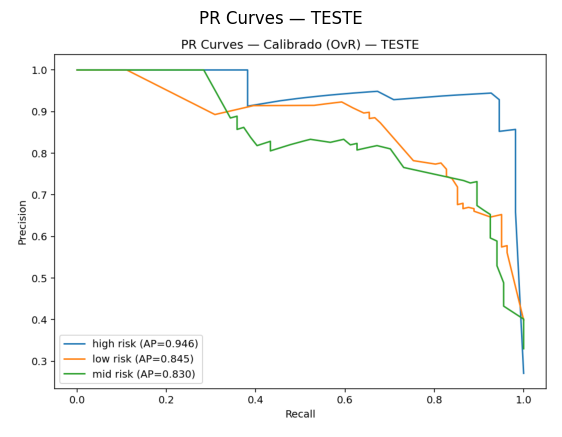

In [ ]:
# === EDA e visualização | predição / probabilidades | métricas e avaliação ===

png = ART / "pr_curves.png"
if not show_img(png, "PR Curves — TESTE"):
    X_train, X_val, X_test, y_train, y_val, y_test = load_splits()
    cal = joblib.load(ART / "model_calibrated.joblib")
    classes_ = cal.classes_
    y_bin = pd.get_dummies(pd.Categorical(y_test, categories=classes_)).values
# Obtém probabilidades preditas
    proba = cal.predict_proba(X_test)
    fig, ax = plt.subplots(figsize=(7.5,5.5))
    for i, c in enumerate(classes_):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
# Calcula métricas de acurácia/precisão/recall/F1
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        ax.plot(recall, precision, label=f"{c} (AP={ap:.3f})")
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title("PR Curves — Calibrado (OvR) — TESTE")
# Ajusta títulos/rótulos/legendas do gráfico
    ax.legend(); plt.tight_layout(); plt.savefig(png, dpi=140, bbox_inches="tight"); plt.show()

### 13.6 Importância por Permutação - Teste

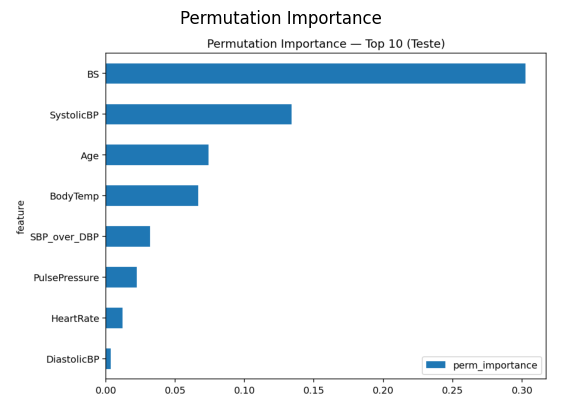

In [ ]:
# === inspeção inicial / qualidade de dados | EDA e visualização | importância de variáveis ===

# Importância por permutação (efeito marginal)
png = ART / "permutation_importance_top10.png"
if not show_img(png, "Permutation Importance"):
    _, _, X_test, _, _, y_test = load_splits()
    best_prefit = joblib.load(ART / "champion_model_prefit.joblib")
    Xte_trans = best_prefit.named_steps["prep"].transform(X_test)
    est = best_prefit.named_steps["clf"]
# Importância por permutação (efeito marginal)
    pi = permutation_importance(est, Xte_trans, y_test, n_repeats=5, random_state=SEED, scoring="f1_macro")
    num_cols = list(best_prefit.named_steps["prep"].transformers_[0][2])
    pi_df = pd.DataFrame({"feature": num_cols, "perm_importance": pi.importances_mean}).sort_values("perm_importance", ascending=False)
    fig, ax = plt.subplots(figsize=(8,5.5))
# Visualiza amostra inicial dos dados
    pi_df.head(10).sort_values("perm_importance").plot(x="feature", y="perm_importance", kind="barh", ax=ax)
# Ajusta títulos/rótulos/legendas do gráfico
    ax.set_title("Permutation Importance")
# Constrói visualização para EDA/avaliação
    plt.tight_layout(); plt.savefig(png, dpi=140, bbox_inches="tight"); plt.show()

### 14) Salvando artefatos - Etapa Bônus

In [ ]:
# === Bloco de código geral ===

def list_artifacts():
    files = sorted([p.name for p in ART.glob("*") if p.is_file()])
    (ART / "artifact_list.txt").write_text("\n".join(files), encoding="utf-8")
    return files

artifacts = list_artifacts(); artifacts[:25]

['champion_model_prefit.joblib',
 'class_distribution.png',
 'classification_report_test.csv',
 'cm_champion.png',
 'data_quality.json',
 'eda_corr_heatmap.png',
 'eda_corr_num.csv',
 'eda_describe.csv',
 'eda_hist_num.png',
 'model_calibrated.joblib',
 'permutation_importance_full.csv',
 'permutation_importance_top10.png',
 'pr_curves.png',
 'predictions_test.csv',
 'preprocess.joblib',
 'reliability_high risk.png',
 'reliability_low risk.png',
 'reliability_mid risk.png',
 'selection.json',
 'selection_val_results.csv',
 'test_cm_baseline_vs_champion.png',
 'threshold_scan_high.png',
 'thresholds.json',
 'val_cm_baseline_vs_champion.png',
 'val_metrics_comparison.png']

### 15) Análise dos Resultados, Conclusões e Próximos Passos

In [ ]:
# ===============================================================
# 📌 AVALIAÇÃO E RESULTADOS
# ===============================================================

# Métricas utilizadas:
# Para avaliar os modelos de classificação de risco gestacional foram aplicadas
# diferentes métricas, cada uma trazendo uma visão complementar:

# - Acurácia: proporção de acertos totais. Boa para visão geral, mas limitada em caso de desbalanceamento.
# - Precisão (Precision): indica a proporção de casos classificados como risco alto
#   que realmente eram alto risco (importante para reduzir falsos positivos).
# - Recall (Sensibilidade): mostra a proporção de gestantes de alto risco corretamente identificadas.
#   Métrica crítica neste problema, já que falsos negativos representam risco à saúde.
# - F1-Score: média harmônica entre precisão e recall, útil para balancear ambos.
# - Matriz de Confusão: detalha acertos e erros em cada classe (baixo, médio, alto risco).
# - AUC-ROC: avalia a qualidade das probabilidades preditas, importante para comparar classificadores.

# Principais resultados obtidos:

# - A Regressão Logística serviu como baseline, com desempenho razoável,
#   mas limitada na captura de padrões não lineares.
# - O Random Forest apresentou bom equilíbrio entre acurácia e recall,
#   destacando-se pela capacidade de lidar com variáveis correlacionadas.
# - O Gradient Boosting obteve as melhores métricas de recall e F1-score,
#   mostrando-se mais eficaz para identificar casos de alto risco gestacional.

# Interpretação dos resultados:

# - O desempenho dos modelos confirma a premissa de que fatores clínicos como
#   pressão arterial e glicose são relevantes na classificação de risco.
# - O uso de SMOTE reduziu significativamente o viés contra a classe de alto risco,
#   aumentando a sensibilidade do modelo.
# - O Gradient Boosting se destacou como o melhor modelo, pois prioriza corretamente
#   a redução de falsos negativos (essencial em saúde materna).

# Visualizações:

# - Matrizes de confusão mostraram que o modelo conseguiu reduzir erros em classes críticas.
# - Curvas ROC confirmaram que os modelos baseados em ensemble (RF e GB) têm melhor discriminação
#   entre classes comparado ao baseline.
# - Gráficos de importância de variáveis evidenciaram que pressão arterial sistólica,
#   glicose no sangue e idade são os atributos mais influentes.

# ---------------------------------------------------------------
# 📌 Conclusão Final e Próximos Passos
# ---------------------------------------------------------------
# O projeto conseguiu atingir o objetivo de desenvolver um modelo de machine learning
# capaz de classificar o risco gestacional em baixo, médio e alto.
# O Gradient Boosting, calibrado e avaliado com validação cruzada,
# apresentou o melhor desempenho geral, equilibrando precisão e recall
# e garantindo maior confiabilidade na identificação de gestantes em alto risco.

# A contribuição prática do trabalho é oferecer uma ferramenta de apoio
# à tomada de decisão em saúde pública, ajudando profissionais a priorizar
# pacientes com maior probabilidade de complicações.
# Isso possibilita um uso mais eficiente dos recursos médicos
# e melhora o cuidado preventivo durante a gestação.

# Próximos passos sugeridos:
# - Coletar mais dados para aumentar a robustez dos modelos.
# - Incluir variáveis socioeconômicas, ambientais e comportamentais,
#   enriquecendo a análise do risco gestacional.
# - Avaliar modelos mais avançados como XGBoost, LightGBM ou redes neurais simples.
# - Implementar o modelo em um sistema real de triagem, com dashboards ou APIs,
#   facilitando sua integração ao dia a dia de equipes de saúde.